To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

[NEW] Llama-3.1 8b, 70b & 405b are trained on a crazy 15 trillion tokens with 128K long context lengths!

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/drive/1T-YBVfnphoVc8E2E854qF3jdia2Ll2W2?usp=sharing)**

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

* We support Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes etc
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] We make Gemma-2 9b / 27b **2x faster**! See our [Gemma-2 9b notebook](https://colab.research.google.com/drive/1vIrqH5uYDQwsJ4-OO3DErvuv4pBgVwk4?usp=sharing)
* [**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
* [**NEW**] We make Mistral NeMo 12B 2x faster and fit in under 12GB of VRAM! [Mistral NeMo notebook](https://colab.research.google.com/drive/17d3U-CAIwzmbDRqbZ9NnpHxCkmXB6LZ0?usp=sharing)

In [2]:
from unsloth import FastLanguageModel
import torch
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder

max_seq_length = 1024
dtype = None  # Auto detection
load_in_4bit = True  # 4bit quantization to reduce memory usage

fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit",
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.4.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj"],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = True, # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # task_type=TaskType.CAUSAL_LM,  # Added to specify the task type
)

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.8 patched 32 layers with 32 QKV layers, 0 O layers and 0 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [4]:
# Load the dataset
dataset = load_dataset("lmsys/lmsys-arena-human-preference-55k", split="train")

# Define target columns and columns to vectorize
target_columns = ['winner_model_a', 'winner_model_b', 'winner_tie']
columns_to_vectorize = ["prompt", "response_a", "response_b"]

# Ensure the target columns are integer types
for col in target_columns:
    dataset = dataset.map(lambda x: {col: int(x[col])})

# Function to find the index of the maximum value in the target columns
def get_label(row):
    values = [row[col] for col in target_columns]
    return values.index(max(values))

# Create the 'label' column based on the index of the maximum value in the target columns
dataset = dataset.map(lambda x: {"label": get_label(x)})

# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset['label'])
dataset = dataset.remove_columns("label")
dataset = dataset.add_column("label", encoded_labels)

# Keep only the columns to vectorize and the encoded 'label' column
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in columns_to_vectorize + ['label']])

In [5]:
# Convert the dataset to a Pandas DataFrame
df = dataset.to_pandas()

# Display the few rows of the DataFrame for verification
df.tail()

,prompt,response_a,response_b,label
57472,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",0
57473,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",0
57474,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",0
57475,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",1
57476,"[""three kids eat three apples in three days, h...","[""27 apples""]","[""If three kids eat three apples in three days...",0


In [6]:
from datasets import Dataset
tokenizer.add_eos_token = True
tokenizer.padding_side = 'right'

LABEL_IDS = [tokenizer(i, add_special_tokens=False)["input_ids"][0] for i in ['a', 'b', 'tie']]

def tokenize(example, tokenizer):
    prompt = tokenizer('<prompt>: ' + " ".join(eval(example['prompt'], {"null": ""})),
                       add_special_tokens=False,
                       padding='max_length', truncation=True,
                       max_length=max_seq_length)["input_ids"]

    response_a = tokenizer('\n\n<response_a>: ' + " ".join(eval(example['response_a'], {"null": ""})),
                           add_special_tokens=False,
                           padding='max_length', truncation=True,
                           max_length=max_seq_length)["input_ids"]

    response_b = tokenizer('\n\n<response_b>: ' + " ".join(eval(example['response_b'], {"null": ""})),
                           add_special_tokens=False,
                           padding='max_length', truncation=True,
                           max_length=max_seq_length)["input_ids"]

    extra_prompt = tokenizer('\n\n---------\nWhich is the better response for the prompt ? a or b or tie ?\n\nAnswer: ',
                             add_special_tokens=False)["input_ids"]

    label_token_id = LABEL_IDS[int(example['label'])]

    input_ids = [tokenizer.bos_token_id] + prompt + response_a + response_b + extra_prompt + [label_token_id] + [tokenizer.eos_token_id]
    attention_mask = [1] * len(input_ids)
    labels = [-100] * len(input_ids)  # Ensure labels have the same length as input_ids for padding

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

def load_data(df, tokenizer):
    raw_datasets = Dataset.from_pandas(df)
    tokenized_datasets = raw_datasets.map(
        tokenize,
        remove_columns=raw_datasets.column_names,
        fn_kwargs={'tokenizer': tokenizer}
    )
    return tokenized_datasets

ds = load_data(df, tokenizer)

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [7]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Clear CUDA cache to free up memory
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds,
    dataset_text_field="input_ids",  # Field containing tokenized input data
    max_seq_length=max_seq_length,
    dataset_num_proc=2,  # Number of processes for data preprocessing
    packing=False,  # Set to False if sequences are long, packing is beneficial for short sequences
    args=TrainingArguments(
        per_device_train_batch_size=1,  # 2 # Set according to your GPU memory; you can try increasing if memory allows
        gradient_accumulation_steps=4,  # 4 # Adjust according to your batch size and training stability
        warmup_steps=10,  # 5 # Short warmup for quick demonstration
        max_steps=200,  # Set to 60 for quick demonstration
        learning_rate=3e-4,  # Lower learning rate to fine-tune effectively; typical range: 2e-5 to 5e-5
        fp16=True,  # Use fp16 if bf16 is not supported by your hardware
        logging_steps=10,  # Log every 10 steps for better tracking
        optim="adamw_8bit",  # Optimizer for efficient training with large models
        weight_decay=0.01,  # Regularization parameter
        lr_scheduler_type="linear",  # Linear scheduler is a good choice for fine-tuning
        seed=3407,  # For reproducibility
        metric_for_best_model="log_loss",
        greater_is_better = False,
        report_to="none",
        output_dir="outputs_141010",  # Directory to save the model and logs
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.984 GB of memory reserved.


In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 57,477 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 200
 "-____-"     Number of trainable parameters = 9,437,184


Step,Training Loss
10,4.379600
20,2.194600
30,1.444200
40,1.204600
50,1.142600
60,1.154000
70,1.229800
80,1.176400
90,1.211600
100,1.205300


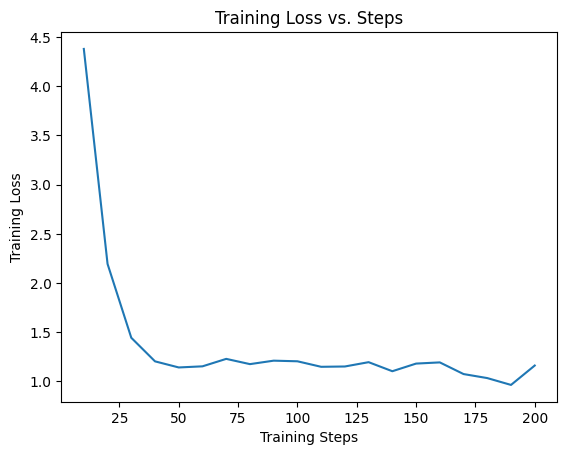

In [9]:
import matplotlib.pyplot as plt

# Assuming `trainer.state.log_history` contains the logged metrics
log_history = trainer.state.log_history

# Extract step and loss values
steps = [entry['step'] for entry in log_history if 'loss' in entry]
losses = [entry['loss'] for entry in log_history if 'loss' in entry]

# Plot the training loss
plt.plot(steps, losses)
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Steps')
plt.show()


In [10]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'start_gpu_memory' is not defined

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/drive/1T-YBVfnphoVc8E2E854qF3jdia2Ll2W2?usp=sharing)**

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nContinue the fibonnaci sequence.\n\n### Input:\n1, 1, 2, 3, 5, 8\n\n### Response:\n13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
13, 21, 34, 55, 89, 144<|end_of_text|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = MAX_LENGTH,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is a famous tall tower in Paris?

### Input:


### Response:
One of the most famous and iconic tall towers in Paris is the Eiffel Tower. Standing at 324 meters (1,063 feet) tall, this wrought iron tower is a symbol of the city and a must-see attraction for tourists from all over the world.<|end_of_text|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/drive/1T-YBVfnphoVc8E2E854qF3jdia2Ll2W2?usp=sharing)**

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)
10. [**NEW**] We make Gemma-2 9b / 27b **2x faster**! See our [Gemma-2 9b notebook](https://colab.research.google.com/drive/1vIrqH5uYDQwsJ4-OO3DErvuv4pBgVwk4?usp=sharing)
11. [**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
12. [**NEW**] We make Mistral NeMo 12B 2x faster and fit in under 12GB of VRAM! [Mistral NeMo notebook](https://colab.research.google.com/drive/17d3U-CAIwzmbDRqbZ9NnpHxCkmXB6LZ0?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>